In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np

The Generalized Least Squares (GLS) estimator is an effective alternative to the Ordinary Least Squares (OLS) estimator for fitting linear models on data sets that exhibit **heteroskedasticity** (i.e., non-constant variance) and/or **autocorrelation**.

<h3> Load Dataset </h3>

In [2]:
data = pd.read_csv('datasets/us_census_bureau_acs_2015_2019_subset.csv', header=0).dropna()

In [3]:
data.head()

,County,Percent_Households_Below_Poverty_Level,Median_Age,Homeowner_Vacancy_Rate,Percent_Pop_25_And_Over_With_College_Or_Higher_Educ
0,"Autauga, Alabama",14.7,38.2,1.4,26.6
1,"Baldwin, Alabama",10.5,43.0,3.3,31.9
2,"Barbour, Alabama",27.5,40.4,3.8,11.6
3,"Bibb, Alabama",18.4,40.9,1.5,10.4
4,"Blount, Alabama",14.2,40.7,0.7,13.1


<h3> Problem Statement </h3>

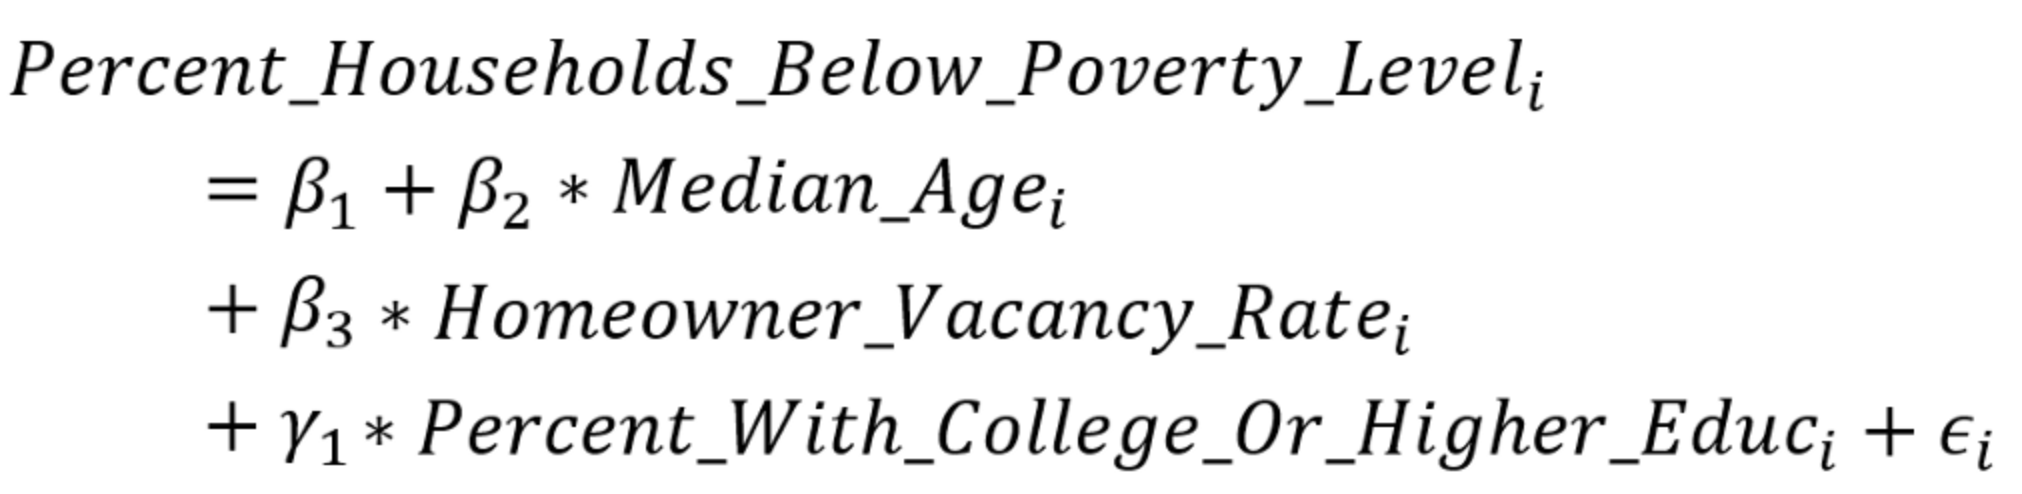

In [4]:
# Define the dependent and independent variables
y = data['Percent_Households_Below_Poverty_Level']
X = data[['Median_Age', 'Homeowner_Vacancy_Rate', 'Percent_Pop_25_And_Over_With_College_Or_Higher_Educ']]

# Add a constant term to the independent variables (for intercept in the regression)
X = sm.add_constant(X)

<h3> OLS Regression Model </h3>

In [5]:
# Fit the linear regression model using OLS
ols_model = sm.OLS(y, X).fit()

# Display the summary of the regression results
print(ols_model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     Percent_Households_Below_Poverty_Level   R-squared:                       0.192
Model:                                                OLS   Adj. R-squared:                  0.191
Method:                                     Least Squares   F-statistic:                     254.6
Date:                                    Tue, 16 Jan 2024   Prob (F-statistic):          3.13e-148
Time:                                            00:02:29   Log-Likelihood:                -10881.
No. Observations:                                    3219   AIC:                         2.177e+04
Df Residuals:                                        3215   BIC:                         2.179e+04
Df Model:                                               3                                         
Covariance Type:                                nonrobust                                         
          

<h3> Residual Diagnostics </h3>

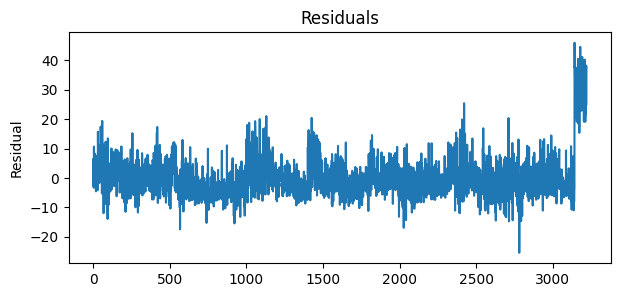

In [6]:
# Get the residuals from the fitted model
residuals = ols_model.resid

# Plot residuals
plt.figure(figsize=(7, 3))
plt.plot(residuals.index, residuals.values)
plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

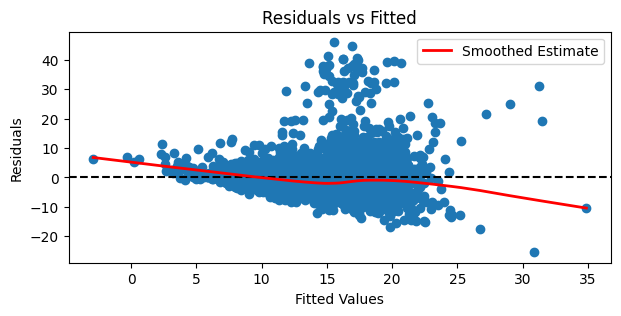

In [7]:
# Create the residuals vs fitted plot
residuals = ols_model.resid
fitted_values = ols_model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.legend()
plt.show()

The model’s errors are clearly heteroskedastic. The use of the GLS estimator is indicated for this data set. 

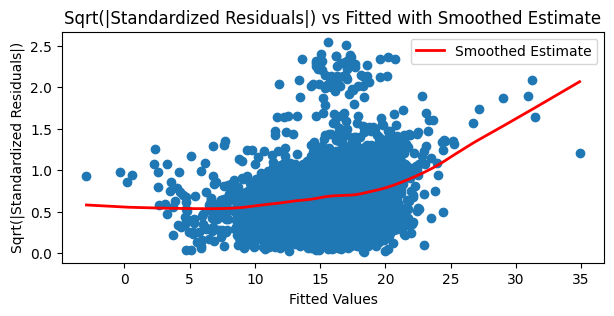

In [8]:
# Create sqrt_abs_standardized_residuals vs fitted plot

# Calculate the standardized residuals
standardized_residuals = ols_model.resid_pearson

# Take the square root of the absolute values of standardized residuals
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Get the fitted values from the fitted model
fitted_values = ols_model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(sqrt_standardized_residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, sqrt_standardized_residuals)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.title('Sqrt(|Standardized Residuals|) vs Fitted with Smoothed Estimate')
plt.legend()
plt.show()

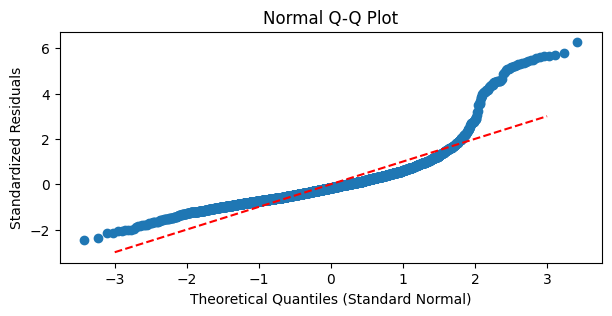

In [9]:
# Plot Normal Q-Q

# Calculate the standardized residuals
standardized_residuals = ols_model.resid_pearson

# Sort the standardized residuals
sorted_standardized_residuals = sorted(standardized_residuals)

# Calculate theoretical quantiles for the standard normal distribution
theoretical_quantiles = np.linspace(0, 100, len(standardized_residuals))  
theoretical_quantiles_values = stats.norm.ppf(theoretical_quantiles / 100)

# Create the normal Q-Q plot of the standardized residuals
plt.figure(figsize=(7,3))
plt.scatter(theoretical_quantiles_values, sorted_standardized_residuals)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='dashed')
plt.xlabel('Theoretical Quantiles (Standard Normal)')
plt.ylabel('Standardized Residuals')
plt.title('Normal Q-Q Plot')
plt.show()

<h3> GLS Regression Model </h3>

<h4> Estimate covariance matrix of errors Σ </h4> 

We’ll use the following procedure for estimating the covariance matrix of errors Σ:

1. Chop up y_cap into intervals of size 1. 
2. For each interval, collect the residual errors from the OLS fitted model and compute their sample variance.
3. Regress these sample variances on the centers of the intervals of y_cap. For e.g. the center of the interval (5, 6] is 5.5.
4. Use this fitted regression model to estimate the sample variance of the residuals of the OLSR model.
5. Use these estimated sample variances of residuals as the estimates of the corresponding error term’s population variances.

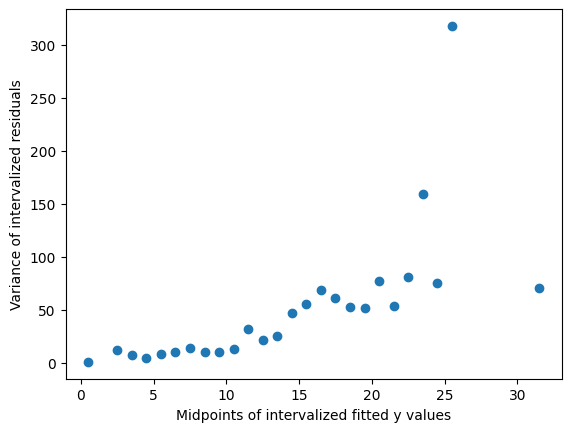

In [10]:
y_cap = ols_model.fittedvalues
residuals = ols_model.resid

# Step1
interval_range=range(round(min(y_cap)), round(max(y_cap)))
ycap_intervals=list(interval_range)
intervalized_ycap=pd.cut(x=y_cap, bins=ycap_intervals)

# Step2
distinct_intervals_of_ycap={}
for intr in list(intervalized_ycap):
    distinct_intervals_of_ycap[intr] = []

series_dict={'Y_CAP':y_cap, 'INTR':intervalized_ycap, 'RESID':residuals}
df_intervalized_ycap = pd.DataFrame(data=series_dict)

for index, row in df_intervalized_ycap.iterrows():
    resid = row['RESID']
    interval = row['INTR']
    distinct_intervals_of_ycap[interval].append(resid)
    
    
midpoints_of_ycap_intervals = []
sample_variance_of_intervalized_residuals = []
 
for key in distinct_intervals_of_ycap.keys():
    if pd.isnull(key):
        continue
    resids = distinct_intervals_of_ycap[key]
    #Skip intervals with <= 1 residual
    if len(resids) > 1:
        sample_variance_of_intervalized_residuals.append(np.var(a=resids, ddof=1))
        midpoints_of_ycap_intervals.append(key.mid)

plt.xlabel('Midpoints of intervalized fitted y values')
plt.ylabel('Variance of intervalized residuals')
plt.scatter(x=midpoints_of_ycap_intervals, y=sample_variance_of_intervalized_residuals)
plt.show()

<p> An exponential relationship between the variance of residuals and the fitted y values is commonly seen when the errors are heteroskedastic. <p>
<p>Let’s build a log-linear model between the intervalized variances and the intervalized fitted y. Specifically, we’ll regress log(sample_variance_of_intervalized_residuals) on midpoints_of_ycap_intervals.</p>

/opt/homebrew/anaconda3/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorica

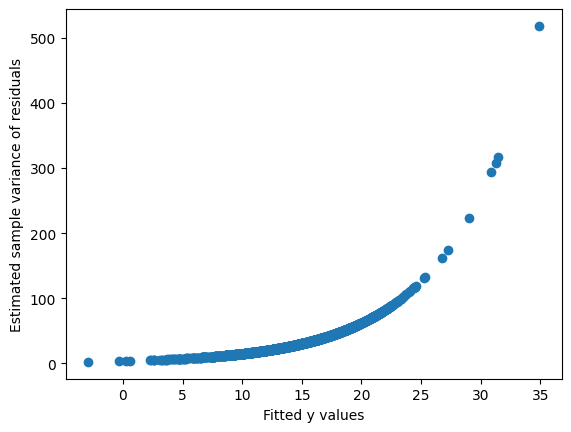

[[4.80568320e+12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.60505393e+10 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.63317196e+30 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.49819170e+17
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.04467820e+13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.48319871e+97]]


In [11]:
# Step 3
log_sample_variance_of_intervalized_residuals = np.log(sample_variance_of_intervalized_residuals)
df_ycap_mids_resid_vars = pd.DataFrame(data={'LOG_INTERVALIZED_RESID_VARIANCE':log_sample_variance_of_intervalized_residuals,'MIDPOINT_INTERVALIZED_YCAP':midpoints_of_ycap_intervals})
 
ols_resid_variance_model = smf.ols('LOG_INTERVALIZED_RESID_VARIANCE ~ MIDPOINT_INTERVALIZED_YCAP',  data=df_ycap_mids_resid_vars) 
ols_resid_variance_model_results = ols_resid_variance_model.fit()


# Step 4
df_ycap_from_ols_model = pd.DataFrame(data={'MIDPOINT_INTERVALIZED_YCAP':y_cap})
 
log_resid_sample_variance_estimate = ols_resid_variance_model_results.predict(df_ycap_from_ols_model['MIDPOINT_INTERVALIZED_YCAP'])
 
resid_sample_variance_estimate = np.exp(log_resid_sample_variance_estimate)

plt.xlabel('Fitted y values')
plt.ylabel('Estimated sample variance of residuals')
plt.scatter(x=y_cap, y=resid_sample_variance_estimate)
plt.show()

# Step 5
sigma_matrix = np.identity(len(y_cap))
np.fill_diagonal(sigma_matrix, np.exp(resid_sample_variance_estimate))
print(sigma_matrix)

In [12]:
# Fit the linear regression model using GLS
gls_model = sm.GLS(y,X,sigma=sigma_matrix).fit()

# Display the summary of the regression results
print(gls_model.summary())

                                      GLS Regression Results                                      
Dep. Variable:     Percent_Households_Below_Poverty_Level   R-squared:                       0.555
Model:                                                GLS   Adj. R-squared:                  0.555
Method:                                     Least Squares   F-statistic:                     1336.
Date:                                    Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                                            00:02:31   Log-Likelihood:                -51015.
No. Observations:                                    3219   AIC:                         1.020e+05
Df Residuals:                                        3215   BIC:                         1.021e+05
Df Model:                                               3                                         
Covariance Type:                                nonrobust                                         
          

<h3> GLS Regression Model Using White's Heteroskedasticity Consistent (HC) Estimator </h3>

In [13]:
# Fit GLS Regression Model using HC Estimator
gls_model_whce = sm.GLS(y,X).fit(cov_type='HC3')

# Display the summary of the regression results
print(gls_model_whce.summary())

                                      GLS Regression Results                                      
Dep. Variable:     Percent_Households_Below_Poverty_Level   R-squared:                       0.192
Model:                                                GLS   Adj. R-squared:                  0.191
Method:                                     Least Squares   F-statistic:                     306.3
Date:                                    Tue, 16 Jan 2024   Prob (F-statistic):          6.74e-175
Time:                                            00:02:31   Log-Likelihood:                -10881.
No. Observations:                                    3219   AIC:                         2.177e+04
Df Residuals:                                        3215   BIC:                         2.179e+04
Df Model:                                               3                                         
Covariance Type:                                      HC3                                         
          

<h3> GLS Regression Model Using Heteroskedasticity & Autocorrelation Consistent (HAC) Estimator </h3>

In [14]:
# Fit GLS Regression Model using HAC Estimator
gls_model_hace = sm.GLS(y,X).fit(cov_type='HAC',cov_kwds={'maxlags': 1})

# Display the summary of the regression results
print(gls_model_hace.summary())

                                      GLS Regression Results                                      
Dep. Variable:     Percent_Households_Below_Poverty_Level   R-squared:                       0.192
Model:                                                GLS   Adj. R-squared:                  0.191
Method:                                     Least Squares   F-statistic:                     279.3
Date:                                    Tue, 16 Jan 2024   Prob (F-statistic):          4.33e-161
Time:                                            00:02:31   Log-Likelihood:                -10881.
No. Observations:                                    3219   AIC:                         2.177e+04
Df Residuals:                                        3215   BIC:                         2.179e+04
Df Model:                                               3                                         
Covariance Type:                                      HAC                                         
          

<h3> Model Comparison OLS vs GLS </h3>

Parameter estimates:
                                                    OLS_Model  GLS_Model
const                                               34.524028  17.486849
Median_Age                                          -0.331736  -0.039147
Homeowner_Vacancy_Rate                               0.919777   0.689959
Percent_Pop_25_And_Over_With_College_Or_Higher_...  -0.316873  -0.157177


Standard errors of parameter estimates:
                                                    OLS_MODEL  GLS_MODEL
const                                                1.076292   0.593117
Median_Age                                           0.024214   0.007747
Homeowner_Vacancy_Rate                               0.087564   0.065087
Percent_Pop_25_And_Over_With_College_Or_Higher_...   0.013379   0.004917


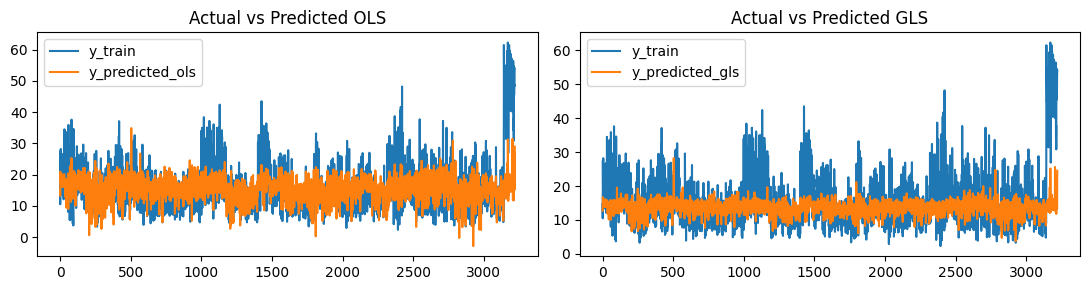

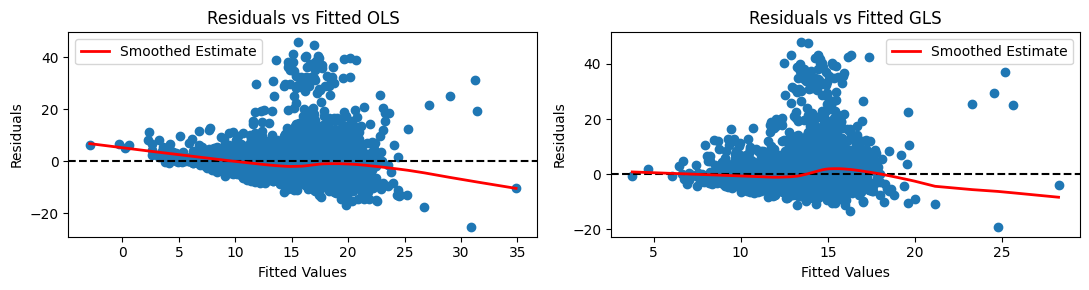

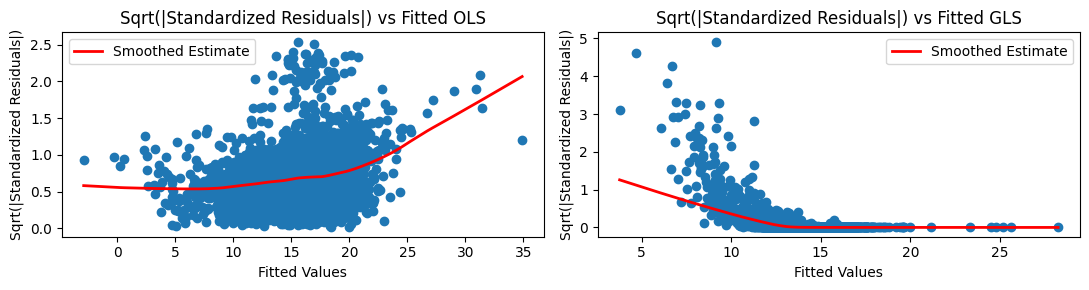

In [15]:
# Compare Parameter Estimates
data={'OLS_Model':ols_model.params, 'GLS_Model':gls_model.params}
print("Parameter estimates:")
print(pd.DataFrame(data=data))

# Compare Parameter Estimates Standard Errors
data={'OLS_MODEL':ols_model.bse, 'GLS_MODEL':gls_model.bse}
print("\n\nStandard errors of parameter estimates:")
print(pd.DataFrame(data=data))



# Plot actual vs predicted y values 
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
y_cap_gls = gls_model.predict(X)
y_cap_ols = ols_model.predict(X)

axes[0].plot(y)
axes[0].plot(y_cap_ols)
axes[0].set_title('Actual vs Predicted OLS')
axes[0].legend(["y_train", "y_predicted_ols"])

axes[1].plot(y)
axes[1].plot(y_cap_gls)
axes[1].set_title('Actual vs Predicted GLS')
axes[1].legend(["y_train", "y_predicted_gls"])

plt.tight_layout()
plt.show()



# Plot the residuals vs fitted
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
residuals_ols = ols_model.resid
fitted_values_ols = ols_model.fittedvalues

residuals_gls = gls_model.resid
fitted_values_gls = gls_model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed_ols = sm.nonparametric.lowess(residuals_ols, fitted_values_ols, frac=0.5)
lowess_smoothed_gls = sm.nonparametric.lowess(residuals_gls, fitted_values_gls, frac=0.5)

axes[0].scatter(fitted_values_ols, residuals_ols)
axes[0].axhline(y=0, color='black', linestyle='dashed')
axes[0].plot(lowess_smoothed_ols[:, 0], lowess_smoothed_ols[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted OLS')
axes[0].legend()

axes[1].scatter(fitted_values_gls, residuals_gls)
axes[1].axhline(y=0, color='black', linestyle='dashed')
axes[1].plot(lowess_smoothed_gls[:, 0], lowess_smoothed_gls[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Fitted GLS')
axes[1].legend()

plt.tight_layout()
plt.show()



# Plot sqrt_abs_standardized_residuals vs fitted 
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

standardized_residuals_ols = ols_model.resid_pearson
sqrt_standardized_residuals_ols = np.sqrt(np.abs(standardized_residuals_ols))
fitted_values_ols = ols_model.fittedvalues

standardized_residuals_gls = gls_model.resid_pearson
sqrt_standardized_residuals_gls = np.sqrt(np.abs(standardized_residuals_gls))
fitted_values_gls = gls_model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed_ols = sm.nonparametric.lowess(sqrt_standardized_residuals_ols, fitted_values_ols, frac=0.5)
lowess_smoothed_gls = sm.nonparametric.lowess(sqrt_standardized_residuals_gls, fitted_values_gls, frac=0.5)

axes[0].scatter(fitted_values_ols, sqrt_standardized_residuals_ols)
axes[0].plot(lowess_smoothed_ols[:, 0], lowess_smoothed_ols[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Sqrt(|Standardized Residuals|)')
axes[0].set_title('Sqrt(|Standardized Residuals|) vs Fitted OLS')
axes[0].legend()

axes[1].scatter(fitted_values_gls, sqrt_standardized_residuals_gls)
axes[1].plot(lowess_smoothed_gls[:, 0], lowess_smoothed_gls[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Sqrt(|Standardized Residuals|)')
axes[1].set_title('Sqrt(|Standardized Residuals|) vs Fitted GLS')

axes[1].legend()
plt.tight_layout()
plt.show()

The GLS estimated model is seen to be more precise than the OLS estimated model for this data set.